# Dataset Link
[Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection?select=Sarcasm_Headlines_Dataset.json)

## Overview of Dataset
Dataset is collected from **TheOnion**, which aims at producing sarcastic versions of current events. Real news headlines was collected from **HuffPost**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [41]:
from pathlib import Path
import json
import re
import string
from string import punctuation
import unicodedata
import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.preprocessing import text, sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GRU
from keras.optimizers import Adam
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint

import gensim



In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
path_v2 = Path("/content/drive/MyDrive/Shared With Others/Sarcasm_Headlines_Dataset_v2.json")
# with open(path_v2) as f:
#   df = json.load(f)

In [5]:
df = pd.read_json(path_v2, lines = True)
df.sample(5)

,is_sarcastic,headline,article_link
21428,0,louis c.k. compares child molesting to eating ...,https://www.huffingtonpost.com/entry/louis-ck-...
25643,1,horse-race announcer clearly had money on 'lit...,https://www.theonion.com/horse-race-announcer-...
23228,1,ama: plastic surgery 'only a few years away' f...,https://www.theonion.com/ama-plastic-surgery-o...
26455,0,uae warns citizens to avoid wearing traditiona...,https://www.huffingtonpost.com/entry/uae-warns...
3192,0,here's why immigration advocates are pressing ...,https://www.huffingtonpost.com/entry/immigrati...


In [6]:
del df['article_link']

# Data Prepocessing and Cleaning

In [7]:
# To remove stopwords and punctuations
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [8]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
  # Remove HTML Elements
  soup = BeautifulSoup(text, "html.parser")
  text = soup.get_text()

  # Remove Brackets
  text = re.sub('\[[^]]*\]', '', text)
  text = re.sub(r'http\S+', '', text)

  text = remove_stopwords(text)
  return text


df['headline'] = df['headline'].apply(denoise_text)

<ipython-input-8-4dbbaa724f7b>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


# Word Embeddings
Representing Document Vocabulary, capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

## [Word2Vec Model](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)

In [9]:
# Converting for Gensim Format
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [10]:
EMBEDDING_DIM = 200

# Creating the word vectors
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size = EMBEDDING_DIM , window = 5 , min_count = 1)

In [11]:
# vocabulary Size
len(w2v_model.wv.key_to_index) # 38065 words with 100 dim vector

38065

In [12]:
tokenizer = text.Tokenizer(num_words = 35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [13]:
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s)
# Thus our vocab size inceeases by 1

vocab_size = len(tokenizer.word_index) + 1

In [14]:
# Create weight matrix from word2vec

def get_weight_matrix(model, vocab):
  # 0 for unknown words
  vocab_size = len(vocab) + 1
  weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [15]:
# Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

### Training W2V Model

In [16]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim = EMBEDDING_DIM, weights = [embedding_vectors], input_length = 20, trainable = True)) # Non trainable, for embedding

# LSTM
model.add(Bidirectional(LSTM(units = 128 , recurrent_dropout = 0.3 , dropout = 0.3, return_sequences = True)))
model.add(Bidirectional(GRU(units = 32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [17]:
del embedding_vectors

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 200)           7613200   
                                                                 
 bidirectional (Bidirection  (None, 20, 256)           336896    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                55680     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 8005841 (30.54 MB)
Trainable params: 8005841 (30.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.25)

In [20]:
epochs_val = 5

In [21]:
history = model.fit(X_train, y_train, batch_size = 128 , validation_data = (X_test,y_test) , epochs = epochs_val)

Epoch 1/5
168/168 [==============================] - 151s 794ms/step - loss: 0.5109 - accuracy: 0.7401 - val_loss: 0.3966 - val_accuracy: 0.8221
Epoch 2/5
168/168 [==============================] - 135s 803ms/step - loss: 0.1573 - accuracy: 0.9405 - val_loss: 0.4713 - val_accuracy: 0.8060
Epoch 3/5
168/168 [==============================] - 139s 825ms/step - loss: 0.0404 - accuracy: 0.9867 - val_loss: 0.7117 - val_accuracy: 0.8050
Epoch 4/5
168/168 [==============================] - 129s 768ms/step - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.9797 - val_accuracy: 0.7990
Epoch 5/5
168/168 [==============================] - 131s 782ms/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 1.0816 - val_accuracy: 0.7969


In [22]:
acc = model.evaluate(X_test,y_test)[1]

224/224 [==============================] - 8s 37ms/step - loss: 1.0816 - accuracy: 0.7969


In [23]:
print("Accuracy : " , acc * 100)

Accuracy :  79.69252467155457


Text(0, 0.5, 'Accuracy')

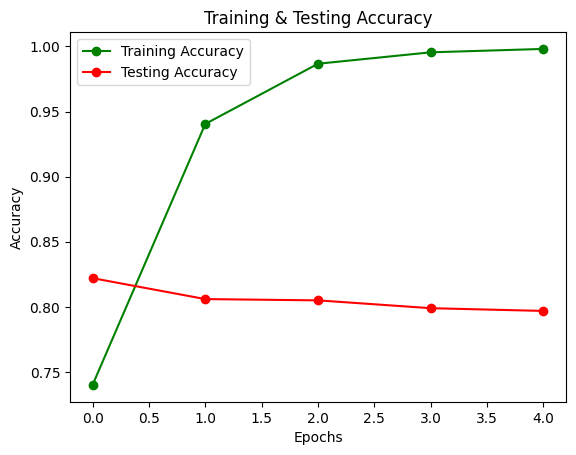

In [24]:
epochs = [i for i in range(epochs_val)]
fig , ax = plt.subplots(1,1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

ax.plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax.plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax.set_title('Training & Testing Accuracy')
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

# GloVe (Attempt 2)

In [42]:
data_1 = pd.read_json("/content/drive/MyDrive/Shared With Others/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/content/drive/MyDrive/Shared With Others/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [43]:
def clean_text(text):
    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [46]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

In [48]:
validation_split = 0.2
max_length = 25


tokenizer_obj = text.Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = sequence.pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658


In [49]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


In [52]:
import os

embeddings_index = {}
embedding_dim = 200
GLOVE_DIR = r'/content/drive/MyDrive/Shared With Others/glove.twitter.27B.200d.txt'
f = open(GLOVE_DIR, encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [53]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24755


In [54]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [55]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 200)           5731600   
                                                                 
 lstm_2 (LSTM)               (None, 64)                67840     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5799505 (22.12 MB)
Trainable params: 67905 (265.25 KB)
Non-trainable params: 5731600 (21.86 MB)
_________________________________________________________________
None


In [57]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=2, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/2
1384/1384 - 121s - loss: 0.4783 - acc: 0.7729 - val_loss: 0.4101 - val_acc: 0.8178 - 121s/epoch - 88ms/step
Epoch 2/2
1384/1384 - 81s - loss: 0.3938 - acc: 0.8216 - val_loss: 0.3540 - val_acc: 0.8463 - 81s/epoch - 58ms/step


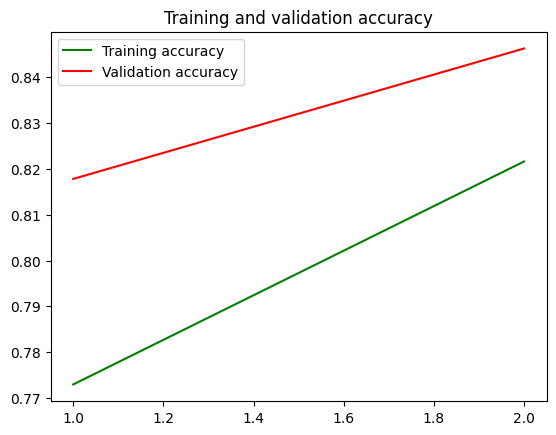

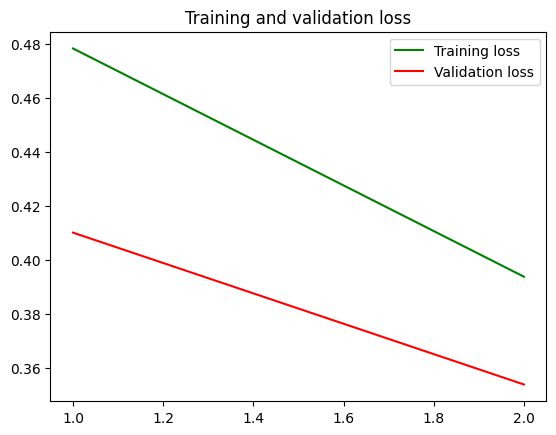

In [59]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [61]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = sequence.pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!"
    else: return "It's not a sarcasm."

In [62]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

1/1 [==============================] - 1s 1s/step


"It's a sarcasm!"

---
---
---
---

## GloVe (NOT WORKING)
Previous model is overfitting

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.headline, df.is_sarcastic, test_size = 0.25)

In [26]:
max_features = 35000
maxlen = 200

In [27]:
tokenizer = text.Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(X_train)

In [28]:
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen = maxlen)

In [29]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test_pad = sequence.pad_sequences(tokenized_test, maxlen = maxlen)

In [30]:
# urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

In [31]:
# !unzip "/content/glove.6B.zip" -d "/content/"

In [32]:
# EMBEDDING_FILE = r'/content/glove.6B.200d.txt'

In [33]:
EMBEDDING_FILE = r'/content/drive/MyDrive/Shared With Others/glove.twitter.27B.200d.txt'

In [34]:
def get_coefs(word, *arr):
  return word, np.asarray(arr, dtype='float32')


embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [35]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
  if i >= nb_words: continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [36]:
batch_size = 128
epochs_val = 5
embed_size = 200

### Training for GloVe Embeddings

In [37]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [38]:
model = Sequential()

model.add(Embedding(nb_words, output_dim = embed_size, weights = [embedding_matrix], input_length = 200, trainable = True))

model.add(Bidirectional(LSTM(units = 128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          5333800   
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               336896    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 5670953 (21.63 MB)
Trainable params: 5670953 (21.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test_pad, y_test) , epochs = epochs_val)

Epoch 1/5
133/168 [======================>.......] - ETA: 2:43 - loss: 0.5019 - accuracy: 0.7553

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/embedding_1/embedding_lookup defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-40-4be1969dc7ea>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 272, in call

indices[73,199] = 26669 is not in [0, 26669)
	 [[{{node sequential_1/embedding_1/embedding_lookup}}]] [Op:__inference_train_function_31006]

In [ ]:
acc = model.evaluate(X_test_pad, y_test)[1]

In [ ]:
print("Accuracy : " , acc * 100)